# Objective

to visualize and export LULC dynamic world map aiming at crops, trees and other land types. The script calculate consistency percentage for specific pixel assigned to specific landcover type and export the consistency map. There are 2 parts to this jupyter notebook:

1. To create consistency map for referencing agricultural pixel throughout study period.

2. To create LULC map for full irrigation coverage and no irrigation coverage. 

# Import librearies

In [3]:
# reading files
import os
import rasterio 
import geopandas as gpd
import pandas as pd

# processing raster
import numpy as np


# visualize raster
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist

--------------------------------------------

## Process LULC file 


** Please run LULC_type for 'grass', 'trees', 'crops', 'bare', and 'shrub_and_scrub' individually

In [11]:
# define wanted landcover and export control
LULC_type = 'grass' # specify one of the: ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
export_LULC = False
memory_save = False

### Extract Landcover type from LULC timeseries images

In [12]:
### extract LULC type in a map
print(f'Processing {LULC_type}')
# define dictinary and value
lulc_dict = {
    'water': 0, 'trees': 1, 'grass': 2, 'flooded_vegetation': 3,
    'crops': 4, 'shrub_and_scrub': 5, 'built': 6, 'bare': 7,
    'snow_and_ice': 8
}

# prepare file directory
folder = 'LULC monthly - dryseason' # select between 'LULC monthly' and 'LULC monthly - dryseason'
LULC_filname_list = [file for file in os.listdir(folder) if file.endswith('.tif')]


# initialize variable to hold stacks
stack_date_list = []
# raster_list = []
stacked_LULC_type = np.empty((len(LULC_filname_list), 12026, 12284), dtype=np.float32)

# iterate over each tif
for index, filename in enumerate(LULC_filname_list):
    # open and read image
    path = os.path.join(folder, filename)
    with rasterio.open(path) as img:
        img = rasterio.open(path)
        raster = img.read(1).astype('float32')
        
        # process nodata
        raster[raster == img.nodata] = None
        # process desired LULC type
        raster[raster != lulc_dict[LULC_type]] = None
        # process profile for export
        img_profile = img.profile
        img_profile.nodata = None
        img_profile['dtype'] = 'float32'


        # [optional] export image
        date = filename[18:25]
        if export_LULC == True:
            name = f'LULC_{LULC_type}_{date}.tif'
            output_path = os.path.join(folder, LULC_type ,name)
            with rasterio.open(output_path, 'w', **img_profile) as dst:
                dst.write(raster, 1)

        # append date and raster to create stack later
        stack_date_list.append(date)
        stacked_LULC_type[index, :, :] = raster
        # raster_list.append(raster)

# remove raster variable that holds iterated raster from memory
if memory_save == True:
    del raster

# print(f'Number of raster: {len(raster_list)}')
print(f'Number of raster: {len(stacked_LULC_type)}')
print(f'Processing date: {stack_date_list[0]} - {stack_date_list[-1]}')

Processing grass
Number of raster: 23
Processing date: 2015-11 - 2019-04


### Calculate consistency

In [4]:
### stack the Lulc raster and calculate consistency
print(f'Processing {LULC_type}')

# initialize array to hold consistency value
LULC_consistency_array = np.full((stacked_LULC_type.shape[1], 
                                  stacked_LULC_type.shape[2]), 
                                  np.nan)
                                 
# process consitency
# iterate through column
for row in np.arange(stacked_LULC_type.shape[1]):
    # iterate through row
    for col in np.arange(stacked_LULC_type.shape[2]):
        # extract timeseries pixel values
        timeseries_LULC = stacked_LULC_type[:, row, col]
        # ignore white space
        if not np.all(np.isnan(timeseries_LULC)):
            consistency_percentage = np.count_nonzero(~np.isnan(timeseries_LULC))/stacked_LULC_type.shape[0] # count non np.nan value/total time
            consistency_percentage = round(consistency_percentage, 2) # get 2 decimal place
            LULC_consistency_array[row,col] = consistency_percentage


Processing bare


KeyboardInterrupt: 

### Save consistency map

In [ ]:
### export LULC consistency at various thresholds

LULC_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for threshold in LULC_thresholds:

# apply thresholds
    LULC_consistency_array_threshold = LULC_consistency_array.copy()
    LULC_consistency_array_threshold[LULC_consistency_array_threshold < threshold] = None

    # export LULC consistency map
    LULC_outdir = os.path.join(folder, LULC_type, f'LULC consistency map - {stacked_LULC_type.shape[0]}t - {LULC_type} - thres{threshold}.tif')
    with rasterio.open(LULC_outdir, 'w', **img_profile) as dst:
        dst.write(LULC_consistency_array_threshold, 1)


### Save Lulc type images as tif

In [13]:
# update profile
img_profile['nodata'] = np.nan
img_profile['count'] = stacked_LULC_type.shape[0]
if 'dry' in folder:
    season = 'dryseason'
else:
    season = 'All month'
folder = 'LULC Type Stack'
os.makedirs(folder, exist_ok= True)
LULC_stack_outdir = os.path.join(folder, f'LULC {LULC_type} stack {stack_date_list[0]} - {stack_date_list[-1]} -- {season}.tif')

with rasterio.open(LULC_stack_outdir, 'w', **img_profile) as src:
    for i, date in enumerate(stack_date_list):
        src.write(stacked_LULC_type[i], i + 1)  # Write the data to band i + 1
        # Set the description for the band
        src.set_band_description(i + 1, date)

------------------------------------------------------------------------------------

# Secondary Objective

To see what is the percentage of pixels devoted to crops over time 

In [3]:
### Reset memory
%reset -f


# import Libraries

In [6]:
# reading files
import os
import rasterio 
import geopandas as gpd
import pandas as pd

# processing raster
import numpy as np


# visualize raster
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from datetime import datetime

# read files

In [7]:
# prepare to read tif files
LULC_folder = 'LULC monthly'
LULC_filenames = [file for file in os.listdir(LULC_folder) 
                  if file.endswith('.tif') and
                  '2pro' in file.lower()]

In [8]:
# loop through each file to extract the pixel count 

# initialize storage variable for pixel count and date
crop_pixel_counts = []
tif_date = []

stack_array = []

for file in LULC_filenames:
    path = os.path.join(LULC_folder, file)

    with rasterio.open(path) as img:
        LULUC_band = img.read()[0]
    crops_pixel_count_band = np.count_nonzero(LULUC_band == 4)
    file_date = file[-26:-19]
    # store 
    crop_pixel_counts.append(crops_pixel_count_band)
    tif_date.append(file_date)
    stack_array.append(LULUC_band)

### process crop pixel count

# count the number of pixels and not white space (may not count water as nodata and water are both 0)
stack_array = np.stack(stack_array, axis = 0)
all_zero_mask = (stack_array == 0).all(axis=0)
total_pixel = np.count_nonzero(all_zero_mask == False)

# percentage the crop pixel count
crop_pixel_percentage = [round(pixel_count/total_pixel * 100, 2) for pixel_count in crop_pixel_counts]

# reformat the date
formatted_dates = [datetime.strptime(date, '%Y-%m').strftime('%Y/%m') for date in tif_date]



''

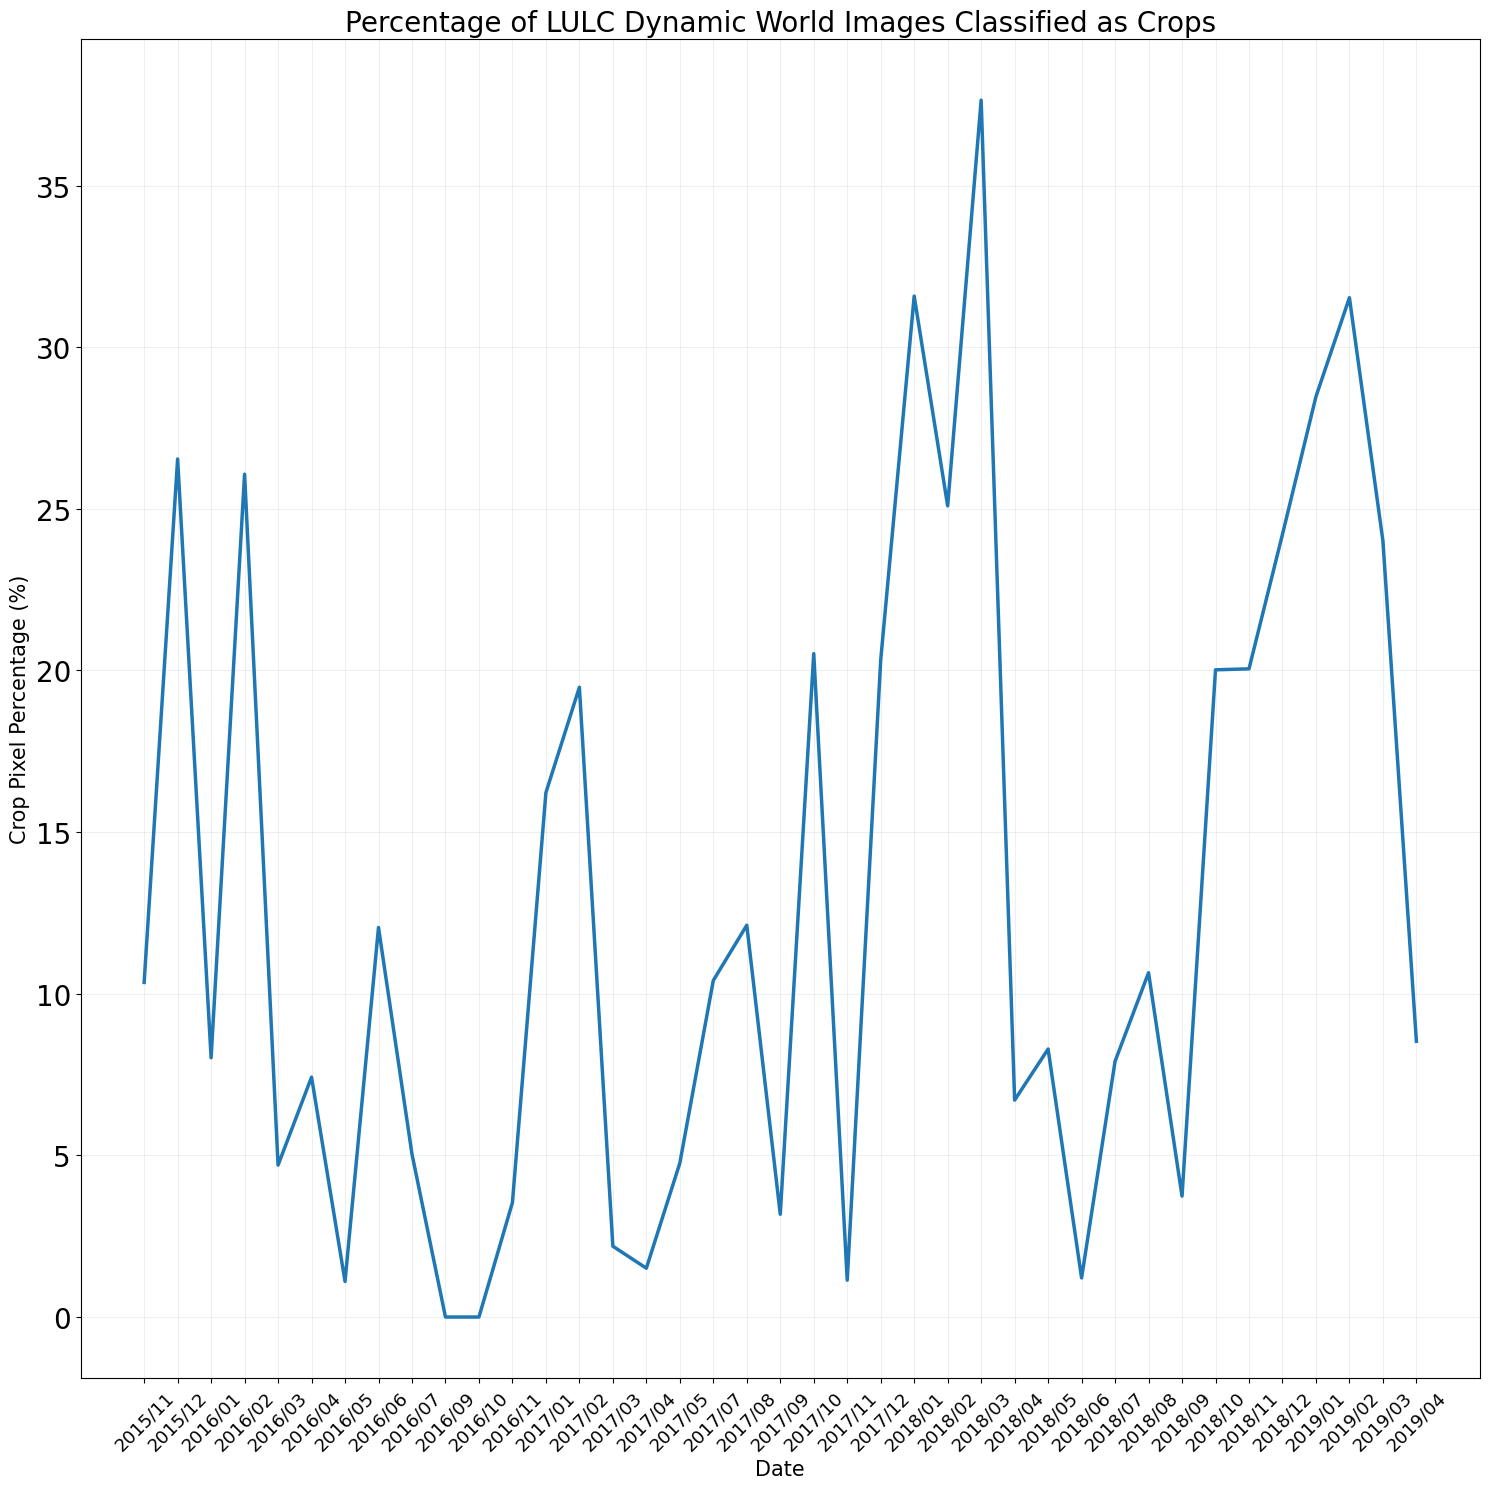

In [10]:
plt.figure(figsize = (15,15))
plt.plot(formatted_dates, crop_pixel_percentage, lw = 2.5)
plt.ylabel('Crop Pixel Percentage (%)', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 20)
plt.title('Percentage of LULC Dynamic World Images Classified as Crops', fontsize = 20)
plt.grid(alpha = 0.2)
plt.tight_layout()
;